 <span style="color:red">  Apart from changing the activation function to ReLU,  I made some changes to stabilize ReLU network training </span>
 
<span style="color:red"> 1. use variance scaling initializer</span>

<span style="color:red"> 2. use bias terms </span>

<span style="color:red"> 3. sgd with momentum use smaller learning rate </span>

references

- [What is the “dying ReLU” problem in neural networks?](https://datascience.stackexchange.com/questions/5706/what-is-the-dying-relu-problem-in-neural-networks)
- [How does rectilinear activation function solve the vanishing gradient problem in neural networks?](https://stats.stackexchange.com/questions/176794/how-does-rectilinear-activation-function-solve-the-vanishing-gradient-problem-in)

# Approximation of a Slice of the Generalized Radon Transform with a Neural Network

In this notebook, I will first introduce the generalized Radon transform and then empirically show its relationship with a deep neural network. First lets look at some definitions.

## Radon Transform 

The standard Radon transform, $\mathcal{R}$, maps a function  $I\in L^1(\mathbb{R}^d)$ where $L^1(\mathbb{R}^d):=\{ I:\mathbb{R}^d \rightarrow \mathbb{R} | \int_{\mathbb{R}^d} |I(x)|dx \leq \infty\}$ to the infinite set of its integrals over the hyperplanes of $\mathbb{R}^d$ and is defined as, 

\begin{eqnarray}
\mathcal{R} I(t,\theta):=\int_{\mathbb{R}^d} I(x)\delta(t-x\cdot\theta)dx,
\end{eqnarray}

for $(t, \theta) \in \mathbb{R} \times \mathbb{S}^{d-1}$ with $\mathbb{S}^{d-1}$ being the unit sphere in $\mathbb{R}^{d}$. 
$\delta(.)$ is the one-dimensional Dirac delta function. Note that $\mathcal{R}: L^1(\mathbb{R}^d)\rightarrow L^1(\mathbb{R}\times \mathbb{S}^{d-1})$. Each hyperplane can be written as:

\begin{equation}
    H(t,\theta)=\{x\in \mathbb{R}^d |x\cdot\theta=t\}
\end{equation}

which alternatively could be thought as the level set of the function $g \in L^1(\mathbb{R}^d\times\mathbb{S}^{d-1})$ defined as $g(x, \theta)=x\cdot\theta$. For a fixed $\theta$, the integrals over all hyperplanes orthogonal to $\theta$ define a continuous function $\mathcal{R}I(\cdot,\theta):\mathbb{R}\rightarrow\mathbb{R}$ which is a projection (or slice) of $I$. 

The Radon transform is a linear bijection (See Natterer 1986 or Helgason 2011) and its inverse, denoted by $\mathcal{R}^{-1}$, is defined as:

\begin{eqnarray}
I(x)&=&\mathcal{R}^{-1}(\mathcal{R}I(t,\theta))\nonumber\\&=& \int_{\mathbb{S}^{d-1}} (\mathcal{R}I(\cdot,\theta)*\eta(\cdot))\circ (x\cdot\theta)d\theta
\end{eqnarray}

where $\eta(\cdot)$ is a one-dimensional high-pass filter with corresponding Fourier transform $\mathcal{F}\eta(\omega)\approx c|\omega|^{d-1}$ (it appears due to the Fourier slice theorem, see Helgason 2011) and "$*$" denotes convolution. The above definition of the inverse Radon transform is also known as the filtered back-projection method, which is extensively used in image reconstruction in the biomedical imaging community. Intuitively each one-dimensional projection/slice, $\mathcal{R}I(\cdot,\theta)$, is first filtered via a high-pass filter and then smeared back into $\mathbb{R}^{d}$ along $L(\cdot,\theta)$ to approximate $I$. The summation of all smeared approximations then reconstruct $I$. Note that in practice, acquiring infinite number of projections is not feasible therefore the integration in the filtered back-projection formulation is often replaced with a finite summation over projections (i.e., a Monte Carlo approximation).

### Radon transform of empirical PDFs: 

 In most machine learning applications we do not have access to the distribution $I$ but to its samples, $x_n$. Kernel density estimation could be used in such scenarios to approximate $I$ from its samples,

\begin{eqnarray}
I(x)\approx \frac{1}{N}\sum_{n=1}^N \phi(x-x_n)
\end{eqnarray} 

where $\phi:\mathbb{R}^d\rightarrow \mathbb{R}^+$ is a density kernel where $\int_{\mathbb{R}^d} \phi(x)dx=1$ (e.g. Gaussian kernel). The Radon transform of  $I$ can then be approximated from its samples:

\begin{eqnarray}
\mathcal{R}I(t,\theta)\approx \frac{1}{N}\sum_{n=1}^N \mathcal{R}\phi(t-x_n\cdot\theta,\theta)
\end{eqnarray} 

 Note that certain density kernels have analytic Radon transformation. For instance when $\phi(x)=\delta(x)$ the Radon transform $\mathcal{R}\phi(t,\theta)=\delta(t)$. Similarly for Gaussian kernels and when $\phi(x)=\mathcal{N}_d(0_d,\sigma^2I_{d\times d})$ the Radon transform is equal to $\mathcal{R}\phi(t,\theta)=\mathcal{N}_1(0,\sigma^2)$. Moreover, given the high-dimensional nature of the problem estimating density $I$ in $\mathbb{R}^d$ requires large number of samples, however,  the projections of $I$, $\mathcal{R}I(.,\theta)$, are one dimensional and therefore it may not be critical to have large number of samples to estimate these one-dimensional densities. 

## Generalized Radon Transform

The Generalized Radon transform (GRT) extends the original idea of the classic Radon transform introduced by \cite{radon1917uber} from integration over hyperplanes of $\mathbb{R}^d$ to integration over hypersurfaces (See Beylkin 1984, Denisyuk 1994, Ehrenpreis 2003, and Homan 2017) (i.e. $(d-1)$-dimensional manifolds). GRT has various applications including Thermoacoustic Tomography (TAT), where the hypersurfaces are spheres, and Electrical Impedance Tomography (EIT), where integration over hyperbolic surfaces appear.


Let $g(x,\theta)$ be a function defined on $\mathcal{X} \times (\mathbb{R}^n \backslash \{ 0 \})$ where $\mathcal{X}$ is a domain in $\mathbb{R}^d$. We say that $g$ is a \emph{defining function} when it satisfies the following conditions:

* $g(x,\theta)$ is a real-valued $C^\infty$ function on $\mathcal{X} \times (\mathbb{R}^n \backslash \{ 0 \})$
* $g(x, \theta)$ is homogeneous of degree one in $\theta$:
    \begin{equation*}
        \forall \lambda \in \mathbb{R},\; g(x, \lambda \theta) = \lambda g(x, \theta)
    \end{equation*}
    
* $g$ is non-degenerate in the sense that $d_x g(x, \theta) \neq 0$ in $\mathcal{X} \times \mathbb{R}^n \backslash \{ 0 \}$

* The mixed Hessian of $g$ is strictly positive, \textit{i.e.} 
    
    \begin{equation*}
        \text{det}\left( \frac{\partial^2 g}{\partial x^i \partial \theta^j} \right) > 0
    \end{equation*}

Then, the generalized Radon transform of $I\in L^1(\mathbb{R}^d)$ is the integration of $I$ over hypersurfaces characterized by the level sets of $g$, which are denoted by:

\begin{equation}
    H_{t,\theta} = \{ x \in \mathcal{X}~|~ g(x, \theta) = t \}
\end{equation} 

In other words, the GRT of $I$ is defined as:
\begin{equation}
    \mathcal{G}I(t,\theta)=\int_{\mathbb{R}^d} I(x)\delta(t-g(x,\theta))dx
\end{equation}

where $g$ is a defining function. 

## Empirical Pilot Studies

Here we would like to focus on a single slice of the generalized Radon transform, where $g(\cdot,\theta)$ is approximated via a deep neural network, $f(\cdot,\gamma)$, where $\gamma$ denotes the parameters of the neural network. 

### Dependencies 

The rest of the code below require:

* Tensorflow
* SKlearn 
* mpl_toolkits
* matplotlib

In [1]:
import numpy as np
import tensorflow as tf

import sklearn
import sklearn.datasets
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KernelDensity


from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib
from matplotlib.ticker import LinearLocator, FormatStrFormatter

from IPython import display
import time
%matplotlib inline

Now we generate the Half Moon dataset

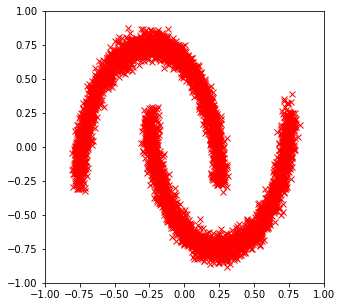

In [2]:
s,label=sklearn.datasets.make_moons(n_samples=5000,noise=.05)
s[:,1]=s[:,1]*2
s-=.5
s=s*.5
plt.figure(figsize=(5,5))
plt.plot(s[:,0],s[:,1],'rx')
plt.axis([-1,1,-1,1])
plt.show()

Lets first generate a $100\times 100$ grid on $[-1,1]$, which we will later use for visualization. 

In [3]:
X,Y=np.meshgrid(np.linspace(-1,1,num=100),np.linspace(-1,1,num=100))
x= np.concatenate((np.reshape(X,(10000,1)),np.reshape(Y,(10000,1))),1)

def plot_node(node, title):
    out=session.run((node),feed_dict={xin:x})
    fig = plt.figure(figsize=(8,8))
    matplotlib.rcParams.update({'font.size': 18})
    ax = fig.gca(projection='3d')
    surf=ax.plot_surface(X, Y, np.reshape(out[:,0],(100,100)),cmap=cm.coolwarm, lw=0.5, rstride=2, cstride=2, alpha=0.75)
    CS=ax.contour(X, Y, np.reshape(out[:,0],(100,100)),30, colors="k", linestyles="solid")    
    ax.view_init(30, -55)
    plt.clabel(CS, inline=2, fontsize=24)
    plt.title(title,fontsize=18)

    fig2=plt.figure(figsize=(5,5))
    kde=KernelDensity(bandwidth=.05)
    kde.fit(X=s)
    I=np.exp(kde.score_samples(x))
    plt.imshow(np.reshape(I,(100,100)),cmap=cm.hot)
    plt.contour(50*X+50, 50*Y+50, np.reshape(out[:,0],(100,100)),20, colors="w", linestyles="solid")
    plt.xticks([])
    plt.yticks([])

    fig3=plt.figure(figsize=(5,5))
    y2=session.run(node,feed_dict={xin:s})
    y2 = y2[:, 0]
    kde1D2=KernelDensity(bandwidth=.05)
    kde1D2.fit(np.array([y2]).T)
    t2=np.linspace(-max(np.abs(y2.min()),np.abs(y2.max()))*1.2,max(np.abs(y2.min()),np.abs(y2.max()))*1.2,1000)
    plt.plot(t2,np.exp(kde1D2.score_samples(np.array([t2]).T)),linewidth=5)
    plt.xticks([])
    plt.yticks([])
    plt.show()

Now we define a neural network with the following architecture $d\rightarrow L_1\rightarrow L_2 \rightarrow L_3 \rightarrow 1\rightarrow K$, where $d=2$ is the input space and $K=2$ is the number of classes. 

In [8]:
def weight_variable(shape):
#   initial = tf.variance_scaling_initializer(seed=0)(shape, tf.float16)
  w = tf.random_normal(shape, dtype=tf.float16, seed=0)
#   initial = w
  initial = w/tf.norm(w, axis=0, keepdims=True)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0., shape = shape, dtype=tf.float16)
  return tf.Variable(initial)

# Architectural parameters
np.random.seed(123)
tf.random.set_random_seed(123)

d=2
L1=50
L2=100
L3=1
# L4=1
# Set a place holder for the input
xin= tf.placeholder(dtype=tf.float16,shape=(None,d))
# Set a place holder for the labels in the one-Hot format (binary classification)
y_=tf.placeholder(tf.float16,shape=(None,2))

# Define the network parameters. I am not using any biases
# theta1=tf.Variable(tf.random_normal((d,L1),dtype=tf.float16))
# theta2=tf.Variable(tf.random_normal((L1,L2),dtype=tf.float16))
# theta3=tf.Variable(tf.random_normal((L2,L3),dtype=tf.float16))
# theta4=tf.Variable(tf.random_normal((L3,L4),dtype=tf.float16))
# theta5=tf.Variable(tf.random_normal((L4,2),dtype=tf.float16))

theta1=weight_variable((d,L1))
b1 = bias_variable((L1,))
theta2=weight_variable((L1,L2))
b2 = bias_variable((L2,))
theta3=weight_variable((L2,L3))
b3 = bias_variable((L3,))
theta4=weight_variable((L3,2))
b4 = bias_variable((2,))
# theta5=weight_variable((L4,2))
# b5 = bias_variable((2,))

# I used Tanh() as nonlinear activation. I also enforce the neural network weights 
# to be unit vectors. The reason behind this is purely geometrical, and the code 
# works without it. The final layer 

activation_f = tf.nn.leaky_relu
# x0 = tf.matmul(xin,tf.nn.l2_normalize(theta1,0))+b1
# x1=activation_f(x0)
# x2=activation_f(tf.matmul(x1,tf.nn.l2_normalize(theta2,0))+b2)
# x3=activation_f(tf.matmul(x2,tf.nn.l2_normalize(theta3,0))+b3)
# # x4=activation_f(tf.matmul(x3,tf.nn.l2_normalize(theta4,0))+b4)
# pred=tf.nn.softmax(tf.matmul(x3,theta4)+b4)

x0 = tf.matmul(xin,theta1)+b1
x1=activation_f(x0)
x2=activation_f(tf.matmul(x1,theta2)+b2)
x3=activation_f(tf.matmul(x2,theta3)+b3)
# x4=activation_f(tf.matmul(x3,tf.nn.l2_normalize(theta4,0))+b4)
pred=tf.nn.softmax(tf.matmul(x3,theta4)+b4)


# I used the cross-entropy loss and simple Gradient Descent as the optimizer. 
# I also define correct_prediction and accuracy variables to monitor training of the network.

cross_entropy=tf.reduce_mean(-y_*tf.log(pred))
# train=tf.train.GradientDescentOptimizer(learning_rate).minimize(cross_entropy)
train=tf.train.MomentumOptimizer(learning_rate=0.05, momentum=0.9).minimize(cross_entropy)

correct_prediction=tf.equal(tf.argmax(pred,1),tf.argmax(y_,1)) 
accuracy=tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

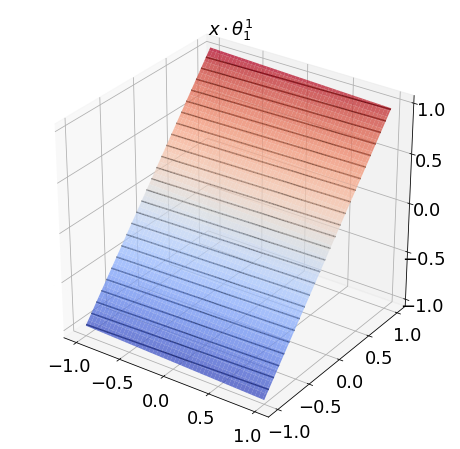

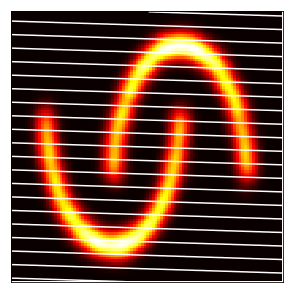

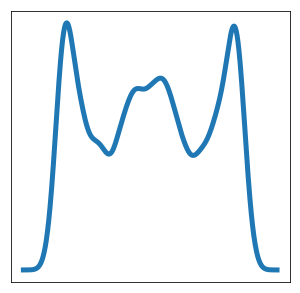

In [9]:
session=tf.Session()
session.run(tf.global_variables_initializer())
with session.as_default():
    plot_node(x0, r'$x\cdot \theta_1^1$')
    

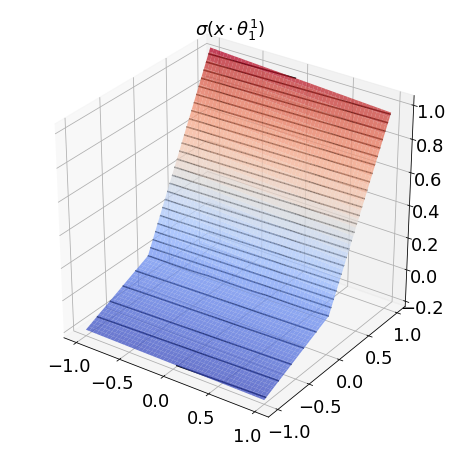

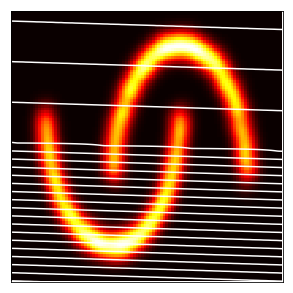

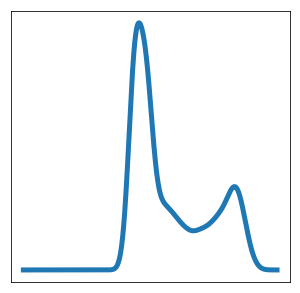

In [10]:
plot_node(x1, r'$\sigma(x\cdot \theta_1^1)$')


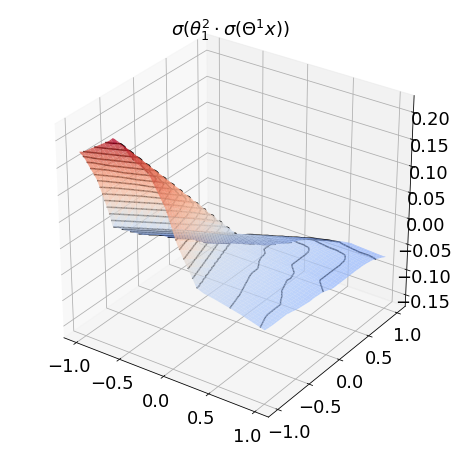

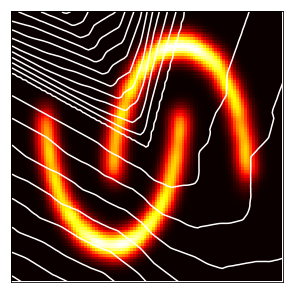

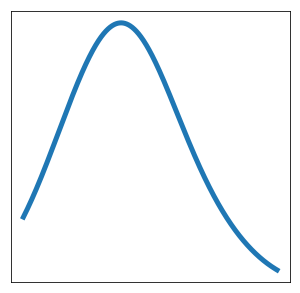

In [11]:
plot_node(x2, r'$\sigma(\theta_1^2 \cdot \sigma(\Theta^1 x))$')


Define the label to oneHot transformer function

In [12]:
def oneHot(y,nofclasses):
    N=y.shape[0]
    label=np.zeros((N,nofclasses))
    for k in np.unique(y):
        label[np.argwhere(y==k),k]=1
    return label

Train the neural network to separate the two modes of the Half Moon dataset. 

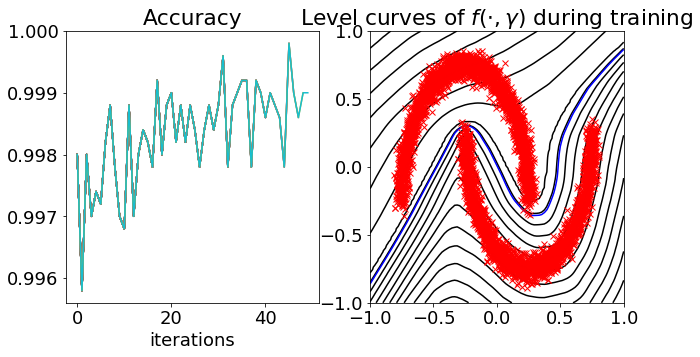

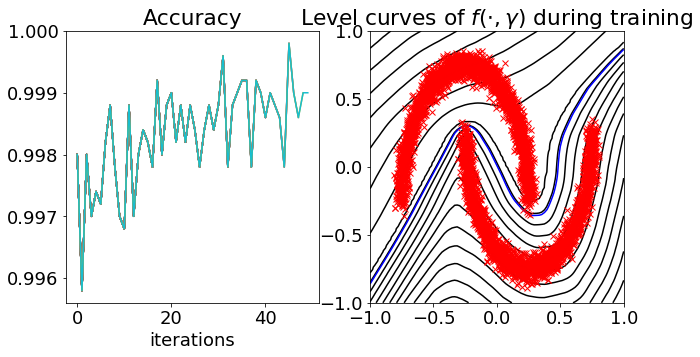

In [22]:
num_epochs=50 #Number of epochs
acc=[] # Accuracy list
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(10,5))
# session.run(tf.global_variables_initializer())
for epoch in range(num_epochs):
    # Generate a batch
    s,label=sklearn.datasets.make_moons(n_samples=5000,noise=.05)
    s[:,1]=s[:,1]*2
    s-=.5
    s=s*.5
    # Run a step
    _,acc_=session.run((train,accuracy),feed_dict={xin:s,y_:oneHot(label,2)})

    # Evaluate the 100x100 grid based on the current f()
    out, theta4_val, b4_val =session.run((x3, theta4, b4),feed_dict={xin:x})
    # w1*x + b1 > w2*x + b2 => x = (b2-b1)/(w1-w2)
    decision_boundary = (b4_val[1] - b4_val[0])/(theta4_val[0, 0] - theta4_val[0, 1])
    
    # Visualize the level curves
    acc.append(acc_)
    ax1.plot(np.asarray(acc))
    ax1.set_title('Accuracy')
    ax1.set_xlabel('iterations')
    ax2.cla()
#     ax2.hold(False)
    ax2.plot(s[:,0],s[:,1],'rx')
#     ax2.hold(True)
    ax2.contour(X, Y, np.reshape(out[:,0],(100,100)),20, colors="k", linestyles="solid")
    ax2.contour(X, Y, np.reshape(out[:,0],(100,100)),[decision_boundary,], colors="b", linestyles="solid")
    ax2.set_title(r'Level curves of $f(\cdot,\gamma)$ during training')
    display.clear_output(wait=True)
    display.display(plt.gcf())
    time.sleep(1e-3)

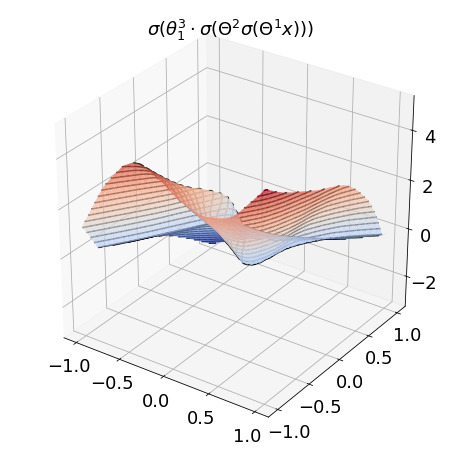

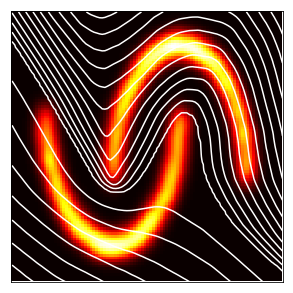

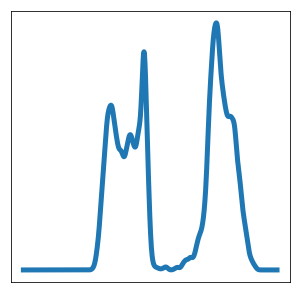

In [23]:
plot_node(x3, r'$\sigma(\theta_1^3 \cdot \sigma(\Theta^2\sigma(\Theta^1 x)))$')